In [1]:
# 16/06/2020
# TASI.AI
# Raphael Mourad

# ARIMA + Exogenous variables = ARIMAX
# ARIMAX is an ARIMA model but in which you can include additional features 
# such as option features to better predict the price.

# https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
import sklearn.metrics as mt
import random
import datetime
from pandas_datareader import DataReader
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from scipy.stats import norm

/home/mourad/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri


In [3]:
# Parameters
symbol="EVER" # Set up the symbol you want
kdays=30 # Number of days for forecasting
kdaysExpi=180 # Number of days until expiration date

In [4]:
# Create folder for symbol
symbolFolder="results/ARIMA_optionstats_features/"+symbol
if(os.path.isdir(symbolFolder)==False):
    os.mkdir(symbolFolder, mode=0o777)

In [5]:
###### LOAD AND PREPROCESS DATA

### STOCK PRICE
# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
#print(data_stockquotes)
print(np.unique(data_stockquotes["symbol"]))

# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel[["symbol","quotedate","close"]]
#data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
print(data_stockquotes_sel)

# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

['AAPL' 'AMZN' 'AXP' 'BA' 'CAT' 'CDLX' 'CHGG' 'CYBR' 'DIS' 'EROS' 'EVER'
 'GOOG' 'GS' 'HD' 'IBM' 'ITRI' 'JNJ' 'JPM' 'KO' 'MCD' 'MRK' 'MSFT' 'NFLX'
 'NIO' 'NKE' 'OSIS' 'PFE' 'PG' 'PRFT' 'XOM']
      symbol  quotedate      close
27623   EVER 2015-05-01  18.850000
27459   EVER 2015-05-04  18.920000
27390   EVER 2015-05-05  18.930000
27732   EVER 2015-05-06  18.750000
27558   EVER 2015-05-07  18.620001
...      ...        ...        ...
27723   EVER 2020-05-22  49.000000
27658   EVER 2020-05-26  46.630000
27458   EVER 2020-05-27  52.120000
27982   EVER 2020-05-28  52.300000
27692   EVER 2020-05-29  53.920000

[649 rows x 3 columns]
Missing data= 0


In [6]:
### STOCK OPTION STATISTICS
# Import optionstats
pathOptionStats="data/optionstats/samples_L3_optionstats_sample.csv.gz"
data_optionStats = pd.read_csv(pathOptionStats, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_optionStats["quotedate"] = pd.to_datetime(data_optionStats["quotedate"])
data_optionStats = data_optionStats.drop(columns=["iv30put","iv30mean","iv60put","iv60mean","iv90put","iv90mean",
                                                 "iv120put","iv120mean","iv150put","iv150mean","iv180put","iv180mean",
                                                 "iv360put","iv360mean"])
print(data_optionStats.columns.values)

# Choose the stock
data_optionStats_sel=data_optionStats[data_optionStats["symbol"]==symbol]
data_optionStats_sel=data_optionStats_sel.sort_values(["quotedate"])
#data_optionStats_sel=data_optionStats_sel.set_index('quotedate')
data_optionStats_sel=pd.DataFrame.drop_duplicates(data_optionStats_sel)
data_optionStats_sel=data_optionStats_sel.drop(columns=["symbol"])
#print(data_optionStats_sel)

# Compute new features from optionstats
# 1 is added to avoid +Inf values
# Call volume / total volume ratio (CTVR)
data_optionStats_sel["CTVR"]=(data_optionStats_sel["callvol"]+1)/(data_optionStats_sel["totalvol"]+1)
# Call oi / total oi ratio (CToiR)
data_optionStats_sel["CToiR"]=(data_optionStats_sel["calloi"]+1)/(data_optionStats_sel["totaloi"]+1)
# Total oi / Total volume ratio (ToiTVR)+1)
data_optionStats_sel["ToiTVR"]=(data_optionStats_sel["totaloi"]+1)/(data_optionStats_sel["totalvol"]+1)
# Current volume / Previous day oi
TVday1=data_optionStats_sel.iloc[1:len(data_optionStats_sel),data_optionStats_sel.columns.values=="totalvol"]
Toiday0=data_optionStats_sel.iloc[0:(len(data_optionStats_sel)-1),data_optionStats_sel.columns.values=="totaloi"]
CVPoi=(TVday1["totalvol"].values+1)/(Toiday0["totaloi"].values+1)
CVPoi=np.append(CVPoi[0],CVPoi)
data_optionStats_sel["CVPoi"]=CVPoi
print(data_optionStats_sel[["iv30call","iv60call",'totalvol','totaloi','CVPoi']])

['symbol' 'quotedate' 'iv30call' 'iv60call' 'iv90call' 'iv120call'
 'iv150call' 'iv180call' 'iv360call' 'callvol' 'putvol' 'totalvol'
 'calloi' 'putoi' 'totaloi']
       iv30call  iv60call  totalvol  totaloi     CVPoi
31857    0.0517    0.0951         0     1466  0.000682
266      0.3993    0.2844         0     1466  0.000682
16857    0.4023    0.2883       129     1466  0.088616
60130    0.3495    0.2575        28     1501  0.019768
3794     0.2532    0.2256         0     1519  0.000666
...         ...       ...       ...      ...       ...
38882    0.7712    0.7687       382     2110  0.240881
44467    0.7666    0.7848       695     2327  0.329702
2980     0.6897    0.6948       235     2477  0.101375
2274     0.7548    0.7415       947     2509  0.382567
45486    0.7018    0.7367       153     2718  0.061355

[648 rows x 5 columns]


In [7]:
### STOCK OPTION FEATURES
# Import option_features
pathOptionFeats="data/options_features/samples_L3_options_features_"+symbol+"_"+str(kdaysExpi)+"daysExpi.csv.gz"
data_optionFeats = pd.read_csv(pathOptionFeats, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
print(data_optionFeats)
data_optionFeats["DataDate"] = pd.to_datetime(data_optionFeats["DataDate"])

       DataDate     PCR     SM     SWM    WMEP  MROI    WMD    WMG     WMT  \
0    2015-05-01   1.000  0.938   0.938  18.850   0.0  0.000  0.002  -0.061   
1    2015-05-04   1.000  0.888   0.888  18.900   0.0  0.000  0.001  -0.044   
2    2015-05-05  80.000  0.875   1.786  17.189   0.0 -0.217  0.107  -0.996   
3    2015-05-06  24.000  0.938   1.697  17.324   0.0 -0.134  0.050  -1.144   
4    2015-05-07   1.000  0.912   0.913  18.575   0.0 -0.000  0.004  -0.097   
..          ...     ...    ...     ...     ...   ...    ...    ...     ...   
643  2020-05-22   0.015  7.400  11.325  55.714   0.0  0.303  0.024 -14.963   
644  2020-05-26   0.002  7.150  28.288  74.393   0.0  0.044  0.007  -3.512   
645  2020-05-27   0.098  7.430   6.070  54.417   0.0  0.540  0.016 -13.540   
646  2020-05-28   0.039  7.425   7.918  59.659   1.0  0.614  0.015 -14.446   
647  2020-05-29   0.224  7.000   6.227  57.992   1.0  0.500  0.022 -19.274   

       WMV  
0    0.081  
1    0.014  
2    3.520  
3    1.233 

In [8]:
### MERGE PRICE WITH OPTION STATS AND OPTION FEATS

# Merge price with option stats
priceOptionStats=data_stockquotes_sel.merge(data_optionStats_sel, left_on='quotedate', right_on='quotedate')

# Merge with option feats
priceOptionStatsFeats=priceOptionStats.merge(data_optionFeats, left_on='quotedate', right_on='DataDate')

# Format table
priceOptionStatsFeats=priceOptionStatsFeats.drop(columns=["symbol","DataDate"])
priceOptionStatsFeats=priceOptionStatsFeats.set_index('quotedate')
#print(priceOptionStats[["close","iv30call","iv30put"]])
print(priceOptionStatsFeats)

                close  iv30call  iv60call  iv90call  iv120call  iv150call  \
quotedate                                                                   
2015-05-01  18.850000    0.0517    0.0951    0.1273     0.1595     0.1809   
2015-05-04  18.920000    0.3993    0.2844    0.2563     0.2283     0.2089   
2015-05-05  18.930000    0.4023    0.2883    0.2540     0.2196     0.1995   
2015-05-06  18.750000    0.3495    0.2575    0.2380     0.2186     0.2077   
2015-05-07  18.620001    0.2532    0.2256    0.2250     0.2244     0.2194   
...               ...       ...       ...       ...        ...        ...   
2020-05-22  49.000000    0.7712    0.7687    0.7959     0.8211     0.8141   
2020-05-26  46.630000    0.7666    0.7848    0.8048     0.8205     0.8171   
2020-05-27  52.120000    0.6897    0.6948    0.7527     0.7952     0.7836   
2020-05-28  52.300000    0.7548    0.7415    0.7965     0.8351     0.8256   
2020-05-29  53.920000    0.7018    0.7367    0.7642     0.7836     0.7829   

In [9]:
###### BUILD AND AUTOSELECT ARIMA MODEL

# Split train/test data
priceOptionStatsTrain = priceOptionStatsFeats[0:(len(priceOptionStatsFeats)-kdays)]
priceOptionStatsTest = priceOptionStatsFeats[(len(priceOptionStatsFeats)-kdays):len(priceOptionStatsFeats)]

priceCloseTrain=priceOptionStatsTrain["close"]
priceCloseTest=priceOptionStatsTest["close"]

exogenousTrain=priceOptionStatsTrain.drop(columns="close")
exogenousTest=priceOptionStatsTest.drop(columns="close")
#print(priceOptionStatsTrain)
#print(priceOptionStatsTest[0:5])

In [10]:
# Build ARIMA model and finding automatically the best ARIMA model (function called auto_arima)
autoARIMA = auto_arima(priceCloseTrain, seasonal=False, trace=True,
                error_action='ignore', suppress_warnings=True, stepwise=True)
ARIMAbestparams=autoARIMA.order
print(ARIMAbestparams)
file_autoARIMA = open(symbolFolder+"/autoARIMA_"+symbol+".txt", "a")
file_autoARIMA.write(str(autoARIMA.summary()))
file_autoARIMA.close()

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=1732.129, BIC=1758.678, Time=0.335 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1785.961, BIC=1794.811, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1769.588, BIC=1782.863, Time=0.044 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1773.153, BIC=1786.428, Time=0.053 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1784.362, BIC=1788.787, Time=0.013 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1764.583, BIC=1786.707, Time=0.127 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1764.937, BIC=1787.062, Time=0.128 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=1733.728, BIC=1764.702, Time=0.354 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=1733.704, BIC=1764.678, Time=0.496 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1764.727, BIC=1782.426, Time=0.084 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercep

In [11]:
# Ranking of exogenous features one by one using AIC
# The higher the loss the better the feature
print("No exo: \tAIC="+str(round(autoARIMA.aic())))

exogenousVars=exogenousTrain.columns.values
AICVars=list()
for k in range(0, len(exogenousVars)):
    vark=exogenousVars[k]
    ARIMAi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[vark]), 
            seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    AICVars.append(ARIMAi.aic())
    print(vark+": \tAIC="+str(round(ARIMAi.aic()))+"\tdiffAIC=",str(round(autoARIMA.aic()-ARIMAi.aic())))

# Save results
matAIC=pd.DataFrame()
matAIC["ExoVar"]=exogenousVars
matAIC["AIC"]=AICVars
matAIC["DiffAIC"]=autoARIMA.aic()-AICVars
matAIC["PercentGainAIC"]=(autoARIMA.aic()-AICVars)/autoARIMA.aic()
pathMatAIC=symbolFolder+"/matrix_ARIMAX_AIC_exogenousVars_"+symbol+".csv"
matAIC.to_csv(pathMatAIC, index=False, sep=',', quotechar='"')

No exo: 	AIC=1732
iv30call: 	AIC=1734	diffAIC= -2
iv60call: 	AIC=1732	diffAIC= 1
iv90call: 	AIC=1729	diffAIC= 3
iv120call: 	AIC=1727	diffAIC= 5
iv150call: 	AIC=1721	diffAIC= 11
iv180call: 	AIC=1726	diffAIC= 6
iv360call: 	AIC=1734	diffAIC= -2
callvol: 	AIC=1759	diffAIC= -27
putvol: 	AIC=1667	diffAIC= 65
totalvol: 	AIC=1744	diffAIC= -12
calloi: 	AIC=1767	diffAIC= -34
putoi: 	AIC=1764	diffAIC= -32
totaloi: 	AIC=1766	diffAIC= -34
CTVR: 	AIC=1734	diffAIC= -2
CToiR: 	AIC=1726	diffAIC= 6
ToiTVR: 	AIC=1766	diffAIC= -34
CVPoi: 	AIC=1734	diffAIC= -2
PCR: 	AIC=1729	diffAIC= 3
SM: 	AIC=1601	diffAIC= 131
SWM: 	AIC=1686	diffAIC= 46
WMEP: 	AIC=1529	diffAIC= 203
MROI: 	AIC=1729	diffAIC= 3
WMD: 	AIC=1712	diffAIC= 20
WMG: 	AIC=1734	diffAIC= -2
WMT: 	AIC=1704	diffAIC= 28
WMV: 	AIC=1704	diffAIC= 28


In [12]:
###### Assess combination of exogenous variables to find the best combination

# List of best exogenous variable candidates
zippedVarSel=zip(matAIC["DiffAIC"],exogenousVars)
exoVarSelected = [element for _, element in sorted(zippedVarSel,reverse=True)]
#print(exoVarSelected)

# ARIMA with exogenous variables
ARIMAexolist=list()
AICVarsList=list()
exolist=list()
for k in range(0, len(exoVarSelected)):
    ARIMAexoi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[exoVarSelected[0:(k+1)]]), seasonal=False, trace=False,
            error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    ARIMAexolist.append(ARIMAexoi)
    AICVarsList.append(ARIMAexoi.aic())
    exolist.append('_'.join(exoVarSelected[0:(k+1)]))
    print("Exo "+str(exoVarSelected[0:(k+1)])+": \tAIC="+str(round(ARIMAexoi.aic()))+"\tdiffAIC="+str(round(autoARIMA.aic()-ARIMAexoi.aic())))
    
# Save results
matAICExoList=pd.DataFrame()
matAICExoList["ExoVarList"]=exolist
matAICExoList["AIC"]=AICVarsList
matAICExoList["DiffAIC"]=autoARIMA.aic()-AICVarsList
matAICExoList["PercentGainAIC"]=(autoARIMA.aic()-AICVarsList)/autoARIMA.aic()
pathMatAICExoList=symbolFolder+"/matrix_ARIMAX_AIC_exogenousVarsList_"+symbol+".csv"
matAICExoList.to_csv(pathMatAICExoList, index=False, sep=',', quotechar='"')

Exo ['WMEP']: 	AIC=1529	diffAIC=203
Exo ['WMEP', 'SM']: 	AIC=1415	diffAIC=317
Exo ['WMEP', 'SM', 'putvol']: 	AIC=1320	diffAIC=412
Exo ['WMEP', 'SM', 'putvol', 'SWM']: 	AIC=1322	diffAIC=410
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT']: 	AIC=1307	diffAIC=425
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT', 'WMV']: 	AIC=1308	diffAIC=424
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT', 'WMV', 'WMD']: 	AIC=1310	diffAIC=422
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT', 'WMV', 'WMD', 'iv150call']: 	AIC=1313	diffAIC=420
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT', 'WMV', 'WMD', 'iv150call', 'CToiR']: 	AIC=1316	diffAIC=416
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT', 'WMV', 'WMD', 'iv150call', 'CToiR', 'iv180call']: 	AIC=1316	diffAIC=417
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT', 'WMV', 'WMD', 'iv150call', 'CToiR', 'iv180call', 'iv120call']: 	AIC=1316	diffAIC=416
Exo ['WMEP', 'SM', 'putvol', 'SWM', 'WMT', 'WMV', 'WMD', 'iv150call', 'CToiR', 'iv180call', 'iv120call', 'PCR']: 	AIC=1299	diffAIC=434
Exo ['WMEP', 'SM', 

In [13]:
###### FORECAST AVERAGE PRICE USING ARIMA MODEL

# Forecast with no exogenous variable (for comparison)
future_forecast_noexo = autoARIMA.predict(n_periods=kdays)

# Forecast for all exogenous variables with ARIMA 
# A ARIMA model is built to predict each exogenous variable.
future_forecast_forexo=pd.DataFrame()
for var in exoVarSelected:
    autoARIMAforexoi = auto_arima(exogenousTrain[var], seasonal=False, trace=False,
                error_action='ignore', suppress_warnings=True, stepwise=True)
    future_forecast_forexoi=pd.DataFrame(autoARIMAforexoi.predict(n_periods=kdays))
    future_forecast_forexo=pd.concat([future_forecast_forexo, future_forecast_forexoi], axis=1)
future_forecast_forexo.columns=exoVarSelected

In [14]:
# Forecast using ARIMA with exogenous variables
RMSEnoexo=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_noexo))
MAEnoexo=mt.mean_absolute_error(priceCloseTest, future_forecast_noexo)

RMSElist=[None] * len(exoVarSelected)
MAElist=[None] * len(exoVarSelected)
ExoVarList=[None] * len(exoVarSelected)
future_forecast_exo_List=[None] * len(exoVarSelected)
conf_int_exo_List=[None] * len(exoVarSelected)
for k in range(0, len(exoVarSelected)):
    future_forecast_exoi, conf_int_exoi = ARIMAexolist[k].predict(n_periods=kdays, return_conf_int=True,alpha=0.05,
                                exogenous=pd.DataFrame(future_forecast_forexo[exoVarSelected[0:(k+1)]]))
    RMSEi=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_exoi))
    RMSElist[k]=RMSEi
    MAEi=mt.mean_absolute_error(priceCloseTest, future_forecast_exoi)
    MAElist[k]=MAEi
    ExoVarList[k]='_'.join(exoVarSelected[0:(k+1)])
    future_forecast_exo_List[k]=future_forecast_exoi
    conf_int_exo_List[k]=conf_int_exoi
    #print(str(exoVarSelected[0:(k+1)]))

/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: Value

In [15]:
# Best models
print("RMSE_noexo: "+str(round(RMSEnoexo,3))+"\tMAE_noexo: "+str(round(MAEnoexo,3))+"\n")

matMetrics=pd.DataFrame()
matMetrics["ExoVar"]=ExoVarList
matMetrics["RMSE"]=np.round(RMSElist,2)
matMetrics["MAE"]=np.round(MAElist,2)
matMetrics["RMSEPercentReduction"]=np.round((RMSElist-RMSEnoexo)/RMSEnoexo,2)
matMetrics["MAEPercentReduction"]=np.round((MAElist-MAEnoexo)/MAEnoexo,2)
print(matMetrics)
print("\nBest model: "+ExoVarList[np.argmin(RMSElist)])

pathMatMetrics=symbolFolder+"/matrix_ARIMAX_metrics_exogenousVarsList_"+symbol+".csv"
matMetrics.to_csv(pathMatMetrics, index=False, sep=',', quotechar='"')

RMSE_noexo: 11.442	MAE_noexo: 9.946

                                               ExoVar   RMSE    MAE  \
0                                                WMEP  11.23   9.72   
1                                             WMEP_SM  11.74  10.26   
2                                      WMEP_SM_putvol  11.49   9.99   
3                                  WMEP_SM_putvol_SWM  11.54  10.04   
4                              WMEP_SM_putvol_SWM_WMT  11.43   9.93   
5                          WMEP_SM_putvol_SWM_WMT_WMV  11.43   9.93   
6                      WMEP_SM_putvol_SWM_WMT_WMV_WMD  11.49   9.99   
7            WMEP_SM_putvol_SWM_WMT_WMV_WMD_iv150call  11.50  10.00   
8      WMEP_SM_putvol_SWM_WMT_WMV_WMD_iv150call_CToiR  11.50   9.99   
9   WMEP_SM_putvol_SWM_WMT_WMV_WMD_iv150call_CToiR...  11.50  10.00   
10  WMEP_SM_putvol_SWM_WMT_WMV_WMD_iv150call_CToiR...  11.48   9.97   
11  WMEP_SM_putvol_SWM_WMT_WMV_WMD_iv150call_CToiR...  11.44   9.93   
12  WMEP_SM_putvol_SWM_WMT_WMV_WMD_iv150

In [16]:
# Forecast with confidence interval (alpha=5%)
future_forecast_exobest=future_forecast_exo_List[np.argmin(RMSElist)]
conf_int_exobest=conf_int_exo_List[np.argmin(RMSElist)]

future_forecast = pd.DataFrame(future_forecast_exobest,columns=['future_forecast'],index=priceCloseTest.index.values)
priceCloseTest = pd.DataFrame(priceCloseTest)
conf_int=conf_int_exobest

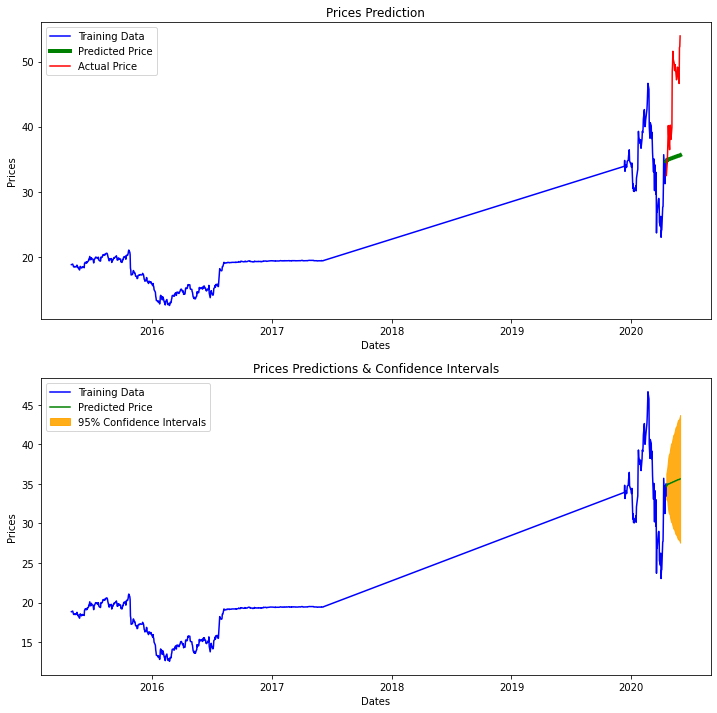

In [17]:
# Better forecast plots
plotForeCastBetter=symbolFolder+"/plot_ARIMA_forecast_better_"+symbol+".pdf"
fig, axes = pyplot.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(priceCloseTrain, color='blue', label='Training Data')
axes[0].plot(priceCloseTest.index, future_forecast, color='green', linewidth=4, label='Predicted Price')

axes[0].plot(priceCloseTest.index, priceCloseTest, color='red', label='Actual Price')
axes[0].set_title('Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(priceCloseTrain, color='blue', label='Training Data')
axes[1].plot(priceCloseTest.index, future_forecast, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(conf_int)
axes[1].fill_between(priceCloseTest.index, conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange', label="95% Confidence Intervals")
axes[1].legend()
pyplot.savefig(plotForeCastBetter, bbox_inches='tight')


mu=35.636
SE=4.11


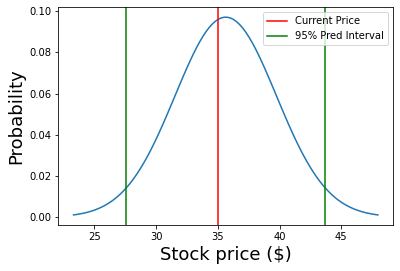

In [18]:
###### PROBABILITY GRAPH FROM ARIMA MODEL

# Note to Rim and Quinn: ARIMA model computes a predicted mean mu at kdays and a 95% confidence interval
# To compute the probability graph (AKA density function in statistics),
# we calculate the Standard Error (SE) from the lower bound of the confidence interval.
# Once we have the mean mu and the SE, then we can plot the probability graph.

# Current price
priceCloseCurrent=priceCloseTrain.iloc[len(priceCloseTrain)-1]

# Extract predicted mean and confidence interval
mu=future_forecast.iloc[kdays-1,0]
lower=conf_int[kdays-1,0]
upper=conf_int[kdays-1,1]
print("mu="+str(round(mu,3)))

# Compute Standard Error (SE) from predicted confidence interval (reverse engineering here ;) )
se=(mu-lower)/norm.ppf(0.975)
print("SE="+str(round(se,3)))

# Probability graph
plotProbabilityGraph=symbolFolder+"/plot_ARIMA_probabilityGraph_"+symbol+"_"+str(kdays)+"days.pdf"
x = np.linspace(mu - 3*se, mu + 3*se, 100)
pyplot.plot(x, norm.pdf(x, mu, se))
pyplot.axvline(x=priceCloseCurrent,color='red',label='Current Price')
pyplot.axvline(x=lower,color='green',label='95% Pred Interval')
pyplot.axvline(x=upper,color='green')
pyplot.xlabel('Stock price ($)', fontsize=18)
pyplot.ylabel('Probability', fontsize=18)
pyplot.legend(loc='upper right')
pyplot.savefig(plotProbabilityGraph, bbox_inches='tight')
pyplot.show()